# Plot feature permutation importance (FPI) results

This notebook will visualize/consolidate the FPI results of the machine learning runs (organized in different branches) in this repositiory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.collections import PatchCollection
#from matplotlib.patches import Rectangle
# Define the repository url to work with and prefix for where it will be copied.
repo_prefix = '~/tmp/'
repo_name = 'sl-archive-whondrs'
repo_url = 'https://github.com/parallelworks/'+repo_name

## Grab data

Since the ML runs are on different branches, we need to jump from branch-to-branch and gather and plot data along the way.

On first branch; clone, checkout, and build feature integer ID lookup table...
fatal: destination path 'sl-archive-whondrs' already exists and is not an empty directory.
Checking out files: 100% (299/299), done.
Switched to branch 'Summer-2019-log10-r04'
Significant features for the ML model on this branch:
1 --- snd_pc_uav
2 --- snd_pc_cav
3 --- slt_pc_cav
4 --- slt_pc_uav
5 --- cly_pc_uav
6 --- cly_pc_cav
7 --- lamO2
8 --- lamO20
9 --- delGd
10 --- delGd0
11 --- delGcox0PerCmol
12 --- GFE
13 --- NOSC
14 --- delGcoxPerCmol
15 --- AI_Mod
16 --- perc_ConHC
17 --- perc_Tannin
18 --- perc_Protein
19 --- perc_Lignin
20 --- DBE
21 --- perc_Lipid
22 --- nli_ix_cav
23 --- hft_ix_c09
24 --- urb_pc_cse
25 --- ppd_pk_cav
26 --- rdd_mk_cav
27 --- nli_ix_uav
28 --- hft_ix_u09
29 --- urb_pc_use
30 --- rdd_mk_uav
31 --- ppd_pk_uav
32 --- pop_ct_csu
33 --- NPOC_Field_mg_per_L_as_C
34 --- perc_Carb
35 --- Percent_Fine_Sand
Checking out files: 100% (296/296), done.
Switched to branch 'Summer-2019-log10

Text(0, 0.5, 'FPI importance ratio (no unit)')

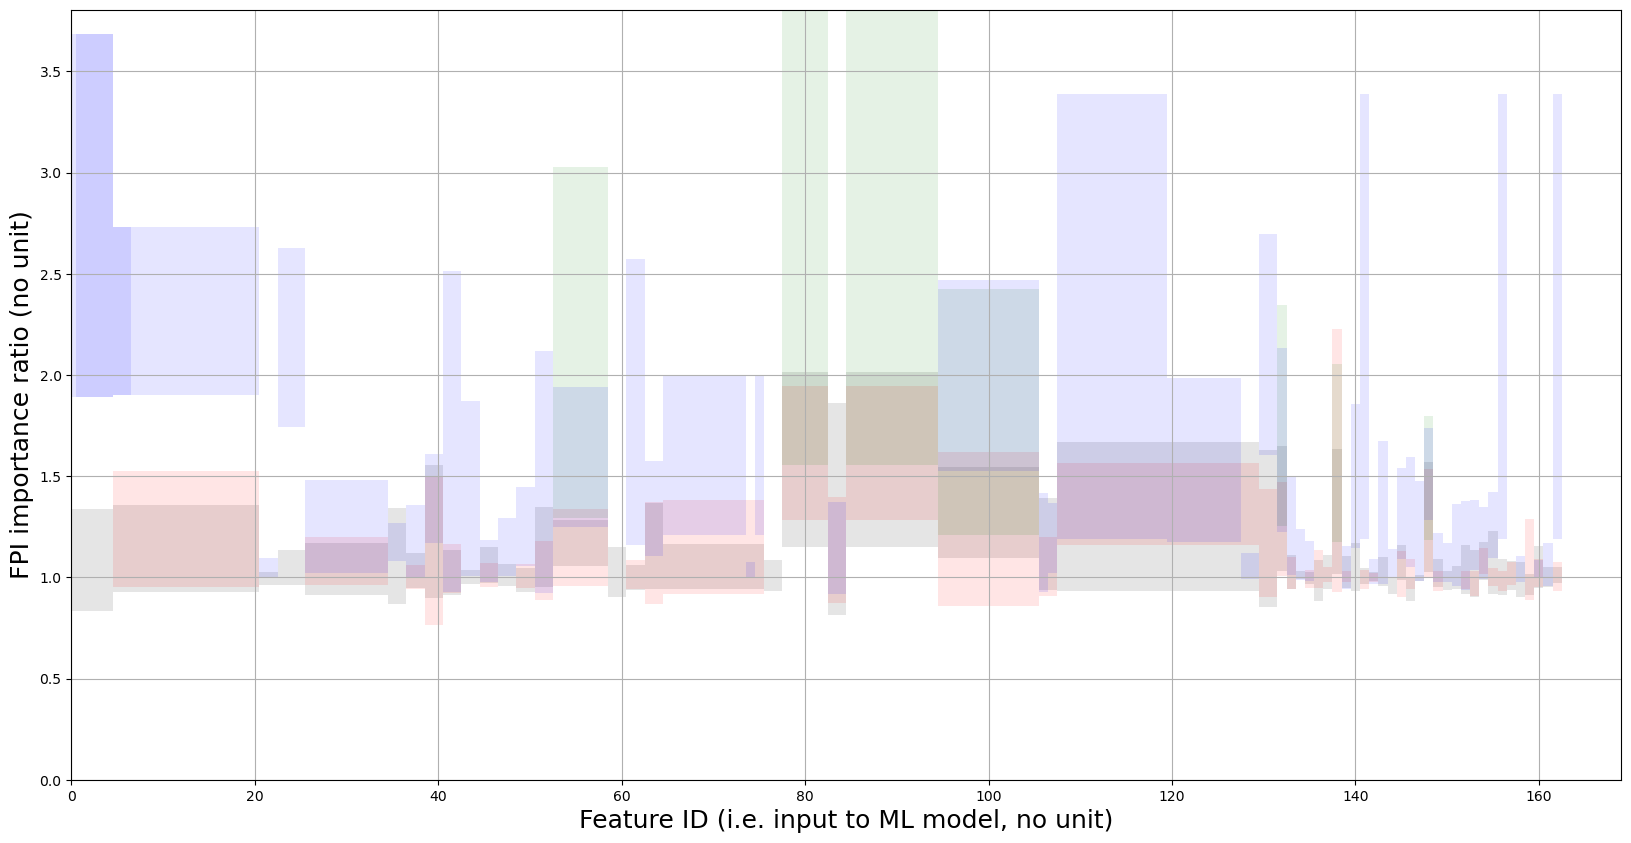

In [2]:
# Make a list of which branches to operate on.
# ASSUME that the first branch will have the most
# complete list of features (i.e. inputs) to the ML
# models. This first list of features will be
# used to create a look-up table for feature-to-feature
# comparisons/visulizations later.

# r01 - all features (163), FPI cutoff = 0.5
# r02 - subset of features (134 - based on r01), FPI cutoff = 0.5
# r03 - subset of features (134 - based on r01), FPI cutoff = 0.7
# r04 - all features (163), FPI cutoff = 0.7
# r05 - subset of featuers (35 - based on r04), FPI cutoff = 0.7
# r05b - repeat r05
# S19S-SSS-log10-r01 - merged S19S-SSS data with no FTICR, all 145 input vars, FPI cutoff = 0.7
list_branches = ['Summer-2019-log10-r04', 'Summer-2019-log10-r03','Summer-2019-log10-r05','S19S-SSS-log10-r01'] #,'Summer-2019-log10-r05b']
list_colors = ['k','r','g','b','c','c']
fpi_max = 0.0

# Initialize empty dataframes
# for model scores and histograms
model_scores = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
train_hist = pd.DataFrame(columns=list_branches)
predict_hist = pd.DataFrame(columns=list_branches)

# Initialize a plot
fig, ax = plt.subplots(1,1,figsize=(20,10))

# Keep track of the number of features discovered as branches are loaded
num_features = 0

for ll,branch in enumerate(list_branches):
    
    # Check for first branch
    if ll == 0:
        print("On first branch; clone, checkout, and build feature integer ID lookup table...")
        ! mkdir -p {repo_prefix}
        ! cd {repo_prefix}; git clone {repo_url}
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
        
        # Load data for look up table only
        fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=False)
        
        # Make the loop up table; need to invert
        # the keys (integers) with the values (feature names)
        # so that feature names can be converted to ints
        # later.
        feature_id_name_dict = dict((v,k) for k,v in fpi_avg['Unnamed: 0'].to_dict().items())
        
        # Count the number of features
        num_featuers = len(feature_id_name_dict)
        
        # Unload the data b/c later we will want to use the index
        del fpi_avg
    else:
        # Set up is complete with first branch, just change to other branches
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # Load data and replace feature names with IDs in dict
    # In the process, get a list of features available in
    # just this branch.
    fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=0)
    branch_feature_names = list(fpi_avg.index)
    fpi_avg.rename(index=feature_id_name_dict, inplace=True)
    
    fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv', index_col=0)
    fpi_std.rename(index=feature_id_name_dict, inplace=True)
    
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    upper = fpi_avg.mean(axis=1)+fpi_avg.std(axis=1)
    lower = fpi_avg.mean(axis=1)-fpi_avg.std(axis=1)
    error = fpi_std.max(axis=1)
    
    # If the max value is bigger than the current value,
    # update it.
    if upper.max() > fpi_max:
        fpi_max = upper.max()
        
    # Start printing out good features:
    print('Significant features for the ML model on this branch:')
    ff = 1
    
    # Plot a box for each feature. We work feature by feature
    # because not all features will be available and not all
    # are chopped out from the edges either; sometimes features
    # will be chopped out from the middle so we don't want to
    # plot continuous lines.
    for feature in branch_feature_names:
        # Check if this feature is in the feature ID dict
        # and if it is not, add it.
        if feature not in feature_id_name_dict:
            num_features = num_features + 1
            feature_id_name_dict[feature] = num_features
        
        # Get feature ID from the dict
        f_id = feature_id_name_dict[feature]
        
        # Get the upper and lower bounds of the box
        f_upper = upper[f_id] 
        f_lower = lower[f_id]
        f_error = error[f_id]
        
        #print(f_id)
        #print(f_upper)
        #print(f_lower)
        #print(f_error)
        
        # Construct the box and plot
        # Loop over data points; create box from errors at each point
        #rect = plt.Rectangle((f_id - 0.5, f_lower), 1.0, f_upper - f_lower, facecolor="black", alpha=0.1)

        left, bottom, width, height = (f_id - 0.5, f_lower, 1.0, f_upper-f_lower)
        #print(left)
        #print(bottom)
        #print(width)
        #print(height)
        
        rect = plt.Rectangle((left, bottom), width, height,
            facecolor=list_colors[ll], alpha=0.1)
        
        # Create patch collection with specified colour/alpha
        #pc = PatchCollection(rect, facecolor='r', alpha=0.5, edgecolor='k')
    
        # Add collection to axes
        ax.add_patch(rect)
        
        # Print out feature name if it is a significant contribution
        # (Here, assume that "significant" means the lowest bound on
        # the FPI improvement ratio is above 1.0)
        if f_lower > 1.0:
            print(str(ff)+" --- "+feature)
            ff = ff + 1
            
    # Clear loaded data
    del fpi_std
    del fpi_avg
    
    # Load model scores
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo_prefix+repo_name+'/input_data/WHONDRS_Data.csv')
    
    model_scores.loc[len(model_scores.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # Grab histograms of the distribution of the target to
    # assess bias in the ML models
    train_all = pd.read_csv(repo_prefix+repo_name+'/input_data/WHONDRS_Data.csv')
    train_hist[branch] = train_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    predict_all = pd.read_csv(repo_prefix+repo_name+'/output_data/unfiltered_predict_output_avg.csv')
    predict_hist[branch] = predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
# Done with looping over branches
ax.grid()

plt.xlim(0,len(feature_id_name_dict))
plt.ylim(0,fpi_max)

plt.xlabel('Feature ID (i.e. input to ML model, no unit)', fontsize=18)
plt.ylabel('FPI importance ratio (no unit)', fontsize=18)

Text(0.5, 0, 'Log10 of respiration rate (log10(mg O2/L/hr))')

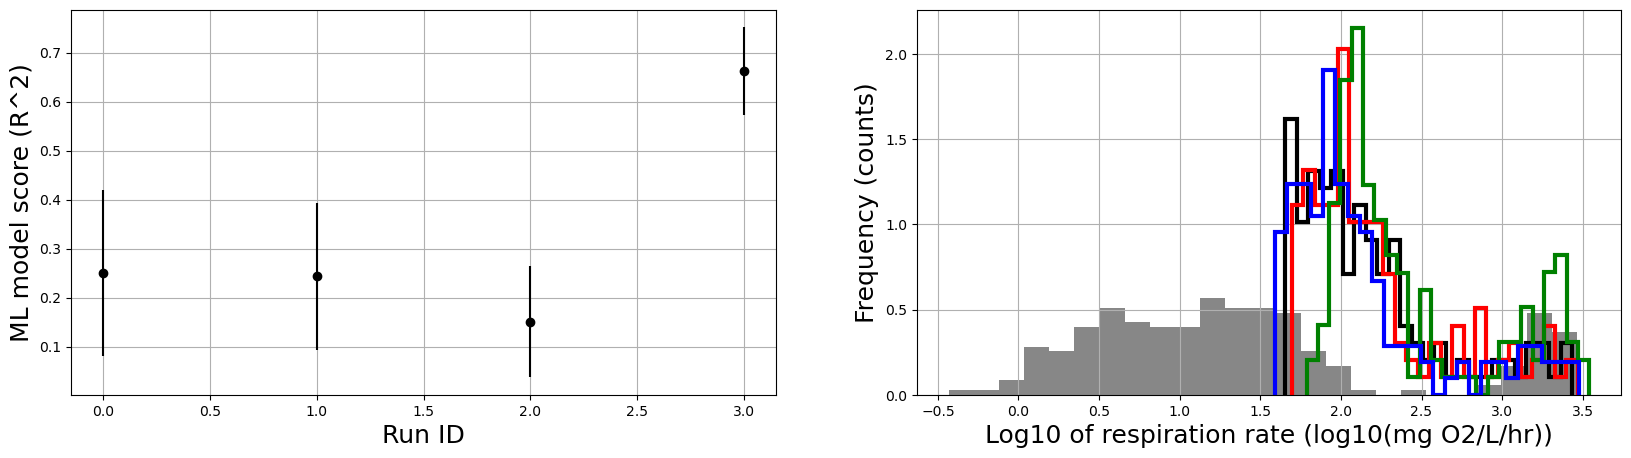

In [3]:
# Set up side-by-side plot
fig, (ax0, ax1)  = plt.subplots(1,2,figsize=(20,5))

# Plot progression of model score with training attempt
ax0.errorbar(model_scores.index, model_scores['hold-out-avg'],yerr=model_scores['hold-out-std'], fmt='ko')
ax0.grid()
ax0.set_xlabel('Run ID', fontsize=18)
ax0.set_ylabel('ML model score (R^2)', fontsize=18)

# Plot progression of histograms (for bias) with training attempt
nbin = 25
for bb,branch in enumerate(list_branches):
    # Histogram for training set truth reference
    n, bins, patches = ax1.hist(
            np.log10(np.abs(train_hist[branch])),
            nbin, density=True, histtype="stepfilled", linestyle=('dashed'), color=('gray'), alpha=0.5)
    
    # Histogram for predictions
    n, bins, patches = ax1.hist(
            np.log10(np.abs(predict_hist[branch])),
            nbin, density=True, histtype="step", linestyle=('solid'), color=(list_colors[bb]), linewidth=3)
    
ax1.grid()
ax1.set_ylabel('Frequency (counts)', fontsize=18)
ax1.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))', fontsize=18)

In [8]:
len(feature_id_name_dict)

170

In [9]:
feature_id_name_dict

{'MiniDot_Sediment_-1hot-_Bedrock (primarily)': 0,
 'MiniDot_Sediment_-1hot-_Gravel/cobble (>2mm)': 1,
 'MiniDot_Sediment_-1hot-_Sand': 2,
 'MiniDot_Sediment_-1hot-_Silt/mud (<0.0625mm)': 3,
 'gla_pc_cse': 4,
 'General_Vegetation_-1hot-_Broadleaf deciduous tree': 5,
 'General_Vegetation_-1hot-_Broadleaf deciduous tree. Crop': 6,
 'General_Vegetation_-1hot-_Broadleaf deciduous tree. Grass': 7,
 'General_Vegetation_-1hot-_Broadleaf deciduous tree. Shrub': 8,
 'General_Vegetation_-1hot-_Broadleaf evergreen tree': 9,
 'General_Vegetation_-1hot-_Broadleaf evergreen tree. Broadleaf deciduous tree': 10,
 'General_Vegetation_-1hot-_Grass': 11,
 'General_Vegetation_-1hot-_Needleleaf deciduous tree. Broadleaf deciduous tree': 12,
 'General_Vegetation_-1hot-_Needleleaf deciduous tree. Grass': 13,
 'General_Vegetation_-1hot-_Needleleaf evergreen tree': 14,
 'General_Vegetation_-1hot-_Needleleaf evergreen tree. Broadleaf deciduous tree': 15,
 'General_Vegetation_-1hot-_Needleleaf evergreen tree. Br